### This notebook trains a model to predict real-time network reliability using QoS metrics from a dynamic network environment using vehicular network data (V2X).

###**Prepared by**: Ndabuye S. Gideon
###**Team**: Hyperion

# Setup and Imports

In [1]:
!pip install -q shap catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from lightgbm import LGBMRegressor as LGB
import numpy as np
import lightgbm as lgbm
import pickle

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, mean_absolute_percentage_error as MAPE, explained_variance_score as EVS
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.ensemble import RandomForestRegressor as RF
from catboost import CatBoostRegressor as CAT
from sklearn.ensemble import HistGradientBoostingRegressor as HIST
from sklearn.model_selection import train_test_split as tts

import shap
shap.initjs()

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# replace with the path of the directory that holds the 'data.parquet' file
path = 'path'

In [4]:
# seed everything for reproducibility
random_seed = 0
random.seed(random_seed)

In [8]:
data = pd.read_parquet(path + 'data.parquet')
data = data.reset_index(drop=True)
data.shape

(207434, 159)

In [9]:
data.head()

,device,ping_ms,datarate,jitter,ts_gps,Latitude,Longitude,Altitude,speed_kmh,COG,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,Traffic Street Name,Traffic Distance,Pos in Ref Round,measurement,area,PCell_RSRP_1,PCell_RSRP_2,PCell_RSRP_max,PCell_RSRQ_1,PCell_RSRQ_2,PCell_RSRQ_max,PCell_RSSI_1,PCell_RSSI_2,PCell_RSSI_max,PCell_SNR_1,PCell_SNR_2,PCell_E-ARFCN,PCell_Downlink_Num_RBs,PCell_Downlink_TB_Size,PCell_Downlink_RBs_MCS_0,PCell_Downlink_RBs_MCS_1,PCell_Downlink_RBs_MCS_2,PCell_Downlink_RBs_MCS_3,PCell_Downlink_RBs_MCS_4,PCell_Downlink_RBs_MCS_5,PCell_Downlink_RBs_MCS_6,PCell_Downlink_RBs_MCS_7,PCell_Downlink_RBs_MCS_8,PCell_Downlink_RBs_MCS_9,PCell_Downlink_RBs_MCS_10,PCell_Downlink_RBs_MCS_11,PCell_Downlink_RBs_MCS_12,PCell_Downlink_RBs_MCS_13,PCell_Downlink_RBs_MCS_14,PCell_Downlink_RBs_MCS_15,PCell_Downlink_RBs_MCS_16,PCell_Downlink_RBs_MCS_17,PCell_Downlink_RBs_MCS_18,PCell_Downlink_RBs_MCS_19,PCell_Downlink_RBs_MCS_20,PCell_Downlink_RBs_MCS_21,PCell_Downlink_RBs_MCS_22,PCell_Downlink_RBs_MCS_23,PCell_Downlink_RBs_MCS_24,PCell_Downlink_RBs_MCS_25,PCell_Downlink_RBs_MCS_26,PCell_Downlink_RBs_MCS_27,PCell_Downlink_RBs_MCS_28,PCell_Downlink_RBs_MCS_29,PCell_Downlink_RBs_MCS_30,PCell_Downlink_RBs_MCS_31,PCell_Downlink_Average_MCS,PCell_Uplink_Num_RBs,PCell_Uplink_TB_Size,PCell_Uplink_Tx_Power_(dBm),PCell_Cell_ID,PCell_Downlink_frequency,PCell_Uplink_frequency,PCell_Downlink_bandwidth_MHz,PCell_Uplink_bandwidth_MHz,PCell_Cell_Identity,PCell_TAC,PCell_Band_Indicator,PCell_MCC,PCell_MNC_Digit,PCell_MNC,PCell_Allowed_Access,PCell_freq_MHz,SCell_RSRP_1,SCell_RSRP_2,SCell_RSRP_max,SCell_RSRQ_1,SCell_RSRQ_2,SCell_RSRQ_max,SCell_RSSI_1,SCell_RSSI_2,SCell_RSSI_max,SCell_SNR_1,SCell_SNR_2,SCell_E-ARFCN,SCell_Downlink_Num_RBs,SCell_Downlink_TB_Size,SCell_Downlink_RBs_MCS_0,SCell_Downlink_RBs_MCS_1,SCell_Downlink_RBs_MCS_2,SCell_Downlink_RBs_MCS_3,SCell_Downlink_RBs_MCS_4,SCell_Downlink_RBs_MCS_5,SCell_Downlink_RBs_MCS_6,SCell_Downlink_RBs_MCS_7,SCell_Downlink_RBs_MCS_8,SCell_Downlink_RBs_MCS_9,SCell_Downlink_RBs_MCS_10,SCell_Downlink_RBs_MCS_11,SCell_Downlink_RBs_MCS_12,SCell_Downlink_RBs_MCS_13,SCell_Downlink_RBs_MCS_14,SCell_Downlink_RBs_MCS_15,SCell_Downlink_RBs_MCS_16,SCell_Downlink_RBs_MCS_17,SCell_Downlink_RBs_MCS_18,SCell_Downlink_RBs_MCS_19,SCell_Downlink_RBs_MCS_20,SCell_Downlink_RBs_MCS_21,SCell_Downlink_RBs_MCS_22,SCell_Downlink_RBs_MCS_23,SCell_Downlink_RBs_MCS_24,SCell_Downlink_RBs_MCS_25,SCell_Downlink_RBs_MCS_26,SCell_Downlink_RBs_MCS_27,SCell_Downlink_RBs_MCS_28,SCell_Downlink_RBs_MCS_29,SCell_Downlink_RBs_MCS_30,SCell_Downlink_RBs_MCS_31,SCell_Downlink_Average_MCS,SCell_Uplink_Num_RBs,SCell_Uplink_TB_Size,SCell_Uplink_Tx_Power_(dBm),SCell_Cell_ID,SCell_Downlink_frequency,SCell_Uplink_frequency,SCell_Downlink_bandwidth_MHz,SCell_Uplink_bandwidth_MHz,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MCC,SCell_MNC_Digit,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,scenario,drive_mode,target_datarate,direction,measured_qos,operator
0,pc4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,None,-83.476250,-85.292500,-83.476250,-14.799375,-14.771875,-14.573125,-48.676250,-50.520625,-50.520625,23.591,21.963,1300.0,39870.0,6433701.0,NaN,156.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,78.0,453.0,1452.5,4480.0,6442.5,12867.5,10880.0,NaN,NaN,3031.5,27.0,973.0,28004.0,120.854749,246.0,1300.0,19300.0,20,20,33802242.0,1494.0,3.0,262.0,2.0,1.0,0.0,1800.0,-84.980625,-86.231875,-84.930000,-10.736250,-9.635625,-9.614375,-54.243750,-56.594375,-56.594375,25.171,24.226,3050.0,46504.0,8422381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,668.0,9604.0,32332.0,NaN,NaN,3900.0,28.0,NaN,NaN,NaN,431.0,3050.0,21050.0,20,20,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,A3D,platoon,350000000

# EDA (Data Decision)

In [10]:
def plot_dist(data, cat, hue, num):
    plt.figure(figsize=(6, 6))

    # Check and report if there are negative values
    if (data[num] < 0).any():
        print(f"Warning: Negative values found in {num}. Consider reviewing the data.")

    # Divide the numerical data by 1e6
    dataf = data.copy()
    dataf[num] = dataf[num] / 1e6

    # Create a violin plot
    sns.violinplot(x=cat, y=num, hue=hue, data=dataf, split=True, inner="quart", palette='Blues')

    plt.xlabel(cat)
    plt.ylabel('Datarate [MBit/s]')

    # Set y-axis limit to start from zero
    plt.ylim(bottom=0)

    # Show the legend
    plt.legend(title=hue, loc='upper right')

    # Show the plot
    plt.show()

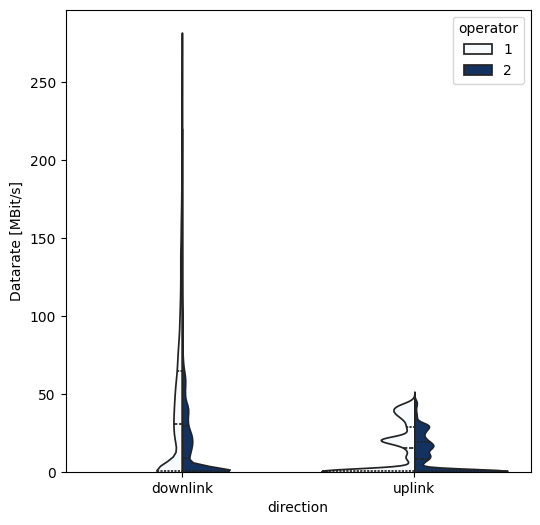

In [ ]:
plot_dist(data, 'direction','operator','datarate')

In [ ]:
def plot_dist_(data, cat, hue, num):
    plt.figure(figsize=(6, 6))

    data_filtered = data[data[cat] != "UNKNOWN"]

    # Divide the numerical data by 1e6
    data_filtered[num] = data_filtered[num] / 1e6

    # Create a violin plot
    sns.violinplot(x=cat, y=num, hue=hue, data=data_filtered, split=True, inner="quart", palette='Blues')

    plt.xlabel(cat)
    plt.ylabel('Datarate [MBit/s]')

    # Set y-axis limit to start from zero
    plt.ylim(bottom=0)

    # Show the legend
    plt.legend(title=hue, loc='upper right')

    # Show the plot
    plt.show()

<ipython-input-50-752e223c50ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[num] = data_filtered[num] / 1e6


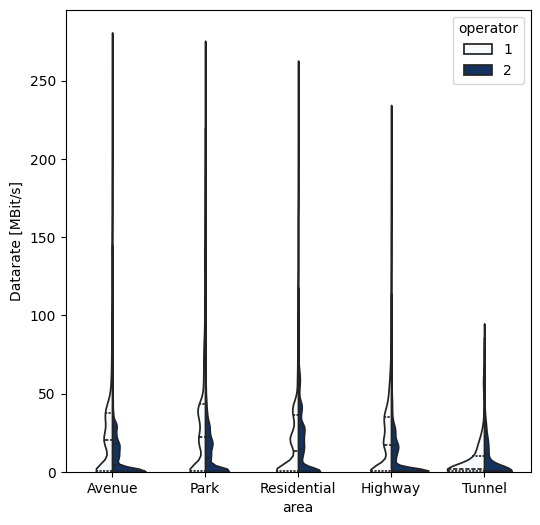

In [ ]:
plot_dist_(data, 'area','operator','datarate')

In [ ]:
data.direction.value_counts()

,count
direction,
uplink,106984
downlink,100450


In [11]:
le = LE()

# function to filter and returning the required data
def get_desired_data(data):
  dff = data.query("measured_qos == 'datarate' & direction == 'downlink'")
  return dff.dropna(subset='datarate')

# function to remove unwanted columns
def remove_cols(data, thres):
  '''remove columns with only one unique value, columns with more than thres % of missing values
  '''
  exp_remove=['device', 'Longitude', 'Latitude', 'Traffic Street Name', 'area'] # remove non-affecting columns
  rem_cols = [a for a in data.columns if data[a].nunique()<=1]
  rem_cols.extend([a for a in data.columns if 'Uplink' in a]) # remove uplink features
  rem_cols.extend(exp_remove)
  miss = data.isna().mean() * 100
  drop_cols = miss[miss > thres].index.tolist()
  drop_cols.extend(rem_cols)
  return data.drop(columns=drop_cols, axis=1)

# function for further preprocessing
def preprocess(df):
  df['hour'] = df.ts_gps.dt.hour
  df = df.drop(['ts_gps'], axis=1)
  df = df.fillna(0)

  # deal with the categorical features
  df.drive_mode = le.fit_transform(df.drive_mode)

  df['PCell_Downlink_bandwidth_MHz'] = df['PCell_Downlink_bandwidth_MHz'].astype('float')
  df.reset_index(drop=True, inplace=True)
  return df


# Pipeline to connect all the three functions
# Create a data preprocessing pipeline (removes all columns with more than 80% of the missing values)
data_pipeline = Pipeline([
    ('get_desired_data', FT(get_desired_data)),
    ('remove_cols', FT(remove_cols, kw_args={'thres': 80})),
    ('preprocess', FT(preprocess))
])

# gets the data w.r.t operator i.e. Operator1=train and Operator2=test
def get_train_test(data):
  return data[data.operator==1], data[data.operator==2]

# function to generate required submission csv file
def submit_csv(r2s, features):
  sub_dict = {
              "team_id": "Hyperion",
              "predicted_qos": "downlink datarate",
              "train_set": "operator 1",
              "test_set": "operator 2",
              "r2_score": r2s,
              "used_features": features,
              }
  scores = pd.DataFrame(sub_dict, index=[0])
  print(scores.to_string())
  scores.to_csv("scores.csv", index=False)

def reg_analysis(y_test, y_pred):
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=y_test, y=y_pred, color='b', alpha=0.7, label='Data Points', )
  sns.lineplot(x=y_test, y=y_test, color='r', label='Regression Line (y=x)')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('Regression Analysis')
  plt.legend()
  plt.show()

# Preprocessing

In [12]:
prep_df = data_pipeline.fit_transform(data)
print(prep_df.shape)
prep_df.head(3)

(52673, 108)


,ping_ms,datarate,jitter,Altitude,speed_kmh,COG,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,Traffic Jam Factor,Traffic Distance,Pos in Ref Round,measurement,PCell_RSRP_1,PCell_RSRP_2,PCell_RSRP_max,PCell_RSRQ_1,PCell_RSRQ_2,PCell_RSRQ_max,PCell_RSSI_1,PCell_RSSI_2,PCell_RSSI_max,PCell_SNR_1,PCell_SNR_2,PCell_E-ARFCN,PCell_Downlink_Num_RBs,PCell_Downlink_TB_Size,PCell_Downlink_RBs_MCS_0,PCell_Downlink_RBs_MCS_1,PCell_Downlink_RBs_MCS_3,PCell_Downlink_RBs_MCS_6,PCell_Downlink_RBs_MCS_7,PCell_Downlink_RBs_MCS_8,PCell_Downlink_RBs_MCS_9,PCell_Downlink_RBs_MCS_11,PCell_Downlink_RBs_MCS_12,PCell_Downlink_RBs_MCS_13,PCell_Downlink_RBs_MCS_14,PCell_Downlink_RBs_MCS_15,PCell_Downlink_RBs_MCS_16,PCell_Downlink_RBs_MCS_17,PCell_Downlink_RBs_MCS_18,PCell_Downlink_RBs_MCS_19,PCell_Downlink_RBs_MCS_20,PCell_Downlink_RBs_MCS_21,PCell_Downlink_RBs_MCS_22,PCell_Downlink_RBs_MCS_23,PCell_Downlink_RBs_MCS_24,PCell_Downlink_RBs_MCS_25,PCell_Downlink_RBs_MCS_26,PCell_Downlink_RBs_MCS_27,PCell_Downlink_RBs_MCS_28,PCell_Downlink_RBs_MCS_29,PCell_Downlink_RBs_MCS_30,PCell_Downlink_RBs_MCS_31,PCell_Downlink_Average_MCS,PCell_Cell_ID,PCell_Downlink_frequency,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_TAC,PCell_Band_Indicator,PCell_MNC,PCell_freq_MHz,SCell_RSRP_1,SCell_RSRP_2,SCell_RSRP_max,SCell_RSRQ_1,SCell_RSRQ_2,SCell_RSRQ_max,SCell_RSSI_1,SCell_RSSI_2,SCell_RSSI_max,SCell_SNR_1,SCell_SNR_2,SCell_E-ARFCN,SCell_Downlink_Num_RBs,SCell_Downlink_TB_Size,SCell_Downlink_RBs_MCS_13,SCell_Downlink_RBs_MCS_14,SCell_Downlink_RBs_MCS_15,SCell_Downlink_RBs_MCS_16,SCell_Downlink_RBs_MCS_18,SCell_Downlink_RBs_MCS_19,SCell_Downlink_RBs_MCS_20,SCell_Downlink_RBs_MCS_21,SCell_Downlink_RBs_MCS_30,SCell_Downlink_RBs_MCS_31,SCell_Downlink_Average_MCS,SCell_Cell_ID,SCell_Downlink_frequency,SCell_Downlink_bandwidth_MHz,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,drive_mode,operator,hour
0,0.0,68700000.0,0.000848,41.9,0.0,0.0,0.0652,0.04,18.15,18.15,14.06,0.77,1011.9,4.07,0.97,3.0,3.44075,51.105265,0.0,0,-76.638750,-79.811875,-76.638750,-14.459375,-14.248750,-14.119375,-42.186875,-45.562500,-45.562500,19.255,22.090,1300.0,29914.0,4381967.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,392.0,1475.0,2287.0,3245.5,1461.0,3801.0,6476.0,4757.5,4120.0,0.0,0.0,1803.0,26.0,246.0,1300.0,20.0,33802242.0,1494.0,3.0,1.0,1800.0,-84.699375,-73.41875,-73.418750,-9.640625,-10.627500,-9.63125,-55.057500,-42.787500,-42.787500,21.968,26.189,3050.0,46392.0,6111069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,376.0,0.0,2398.0,24.0,431.0,3050.0,20,33802248.0,1494.0,7.0,1.0,0.0,2600.0,1,1,9.0
1,0.0,24500000.0,0.000512,35.3,0.0,259.0,0.0652,0.04,18.15,18.15,14.06,0.77,1011.9,4.07,0.97,3.0,3.44075,49.434102,0.0,0,-98.241250,-126.817500,-98.241250,-20.347500,-19.831875,-19.696250,-57.894375,-86.988750,-86.988750,4.777,-1.572,1801.0,41539.0,2343621.0,4.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,528.0,268.0,792.0,0.0,776.0,2445.0,9160.0,8977.0,2151.0,10369.0,1592.0,2072.0,872.0,0.0,0.0,0.0,0.0,1380.0,22.0,223.0,1801.0,20.0,51842568.0,49101.0,3.0,2.0,1800.0,-103.427500,-129.77250,-103.427500,-15.051250,-18.415625,-15.05125,-68.375625,-91.360000,-91.360000,1.748,-6.208,2850.0,51880.0,1214004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,0.0,12.0,53.0,2850.0,20,51842565.0,49101.0,7.0,2.0,0.0,2600.0,1,2,9.0
2,0.0,49800000.0,0.000090,30.7,0.0,0.0,0.0653,0.04,18.13,18.13,14.04,0.77,1011.9,4.07,0.97,3.0,2.53146,35.077388,0.0,0,-97.986875,-97.394375,-97.028125,-12.315625,-14.068750,-12.309375,-65.670000,-63.323125,-63.323125,10.339,9.160,2850.0,43804.0,2951559.0,0.0,8.0,0.0,0.0,0.0,4.0,0.0,8.0,1744.0,1920.0,588.0,1876.0,0.0,256.0,72.0,0.0,0.0,0.0,1647.0,11952.0,6724.0,9728.0,5494.0,96.0,0.0,0.0,303.0,1384.0,23.0,53.0,2850.0,20.0,51842565.0,49101.0,7.0,2.0,2600.0,-95.426875,-94.18250,-94.158125,-17.901875,-19.158750,-17.82000,-57.528125,-55.024375,-55.024375,10.093,11.19

# Modelling

## Feature Selection

In [13]:
train, test = get_train_test(prep_df)

train.shape, test.shape

((29118, 108), (23555, 108))

In [14]:
rcols = ['operator', 'datarate'] # target and operator columns to remove

# training set
X = train.drop(columns=rcols, axis=1).astype('float')
y = train.datarate

# make test set
x_test = test.drop(columns=rcols, axis=1).astype('float')
y_test = test.datarate

x_test.shape

print(f'Train Shape: {X.shape} \nTest Shape: {x_test.shape}')

Train Shape: (29118, 106) 
Test Shape: (23555, 106)


In [15]:
def eval(y_test, y_pred):
  print(f'RMSE: {MSE(y_test, y_pred, squared=False)}')
  print(f'MAE: {MAE(y_test, y_pred)}')
  print(f'MAPE: {MAPE(y_test, y_pred)}')
  print(f'R2: {r2_score(y_test, y_pred)}')
  print(f'EVS: {EVS(y_test, y_pred)}')

In [16]:
# create a dummy model for feature importance evaluation
model = LGB(verbose=-100, random_state=0)

# fit model
model.fit(X, y)

LGBMRegressor(random_state=0, verbose=-100)

<Axes: xlabel='datarate', ylabel='Count'>

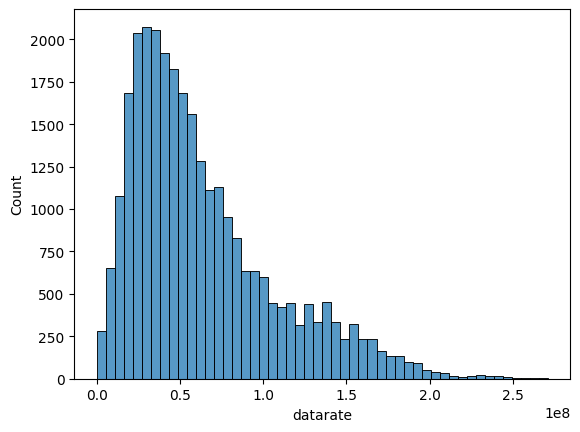

In [ ]:
sns.histplot(y, bins=50)

In [18]:
y_pred = model.predict(x_test)

eval(y_test, y_pred)

RMSE: 6316227.039988163
MAE: 4106136.3029155554
MAPE: 0.811402879176155
R2: 0.9189738520496289
EVS: 0.9227580216421796


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


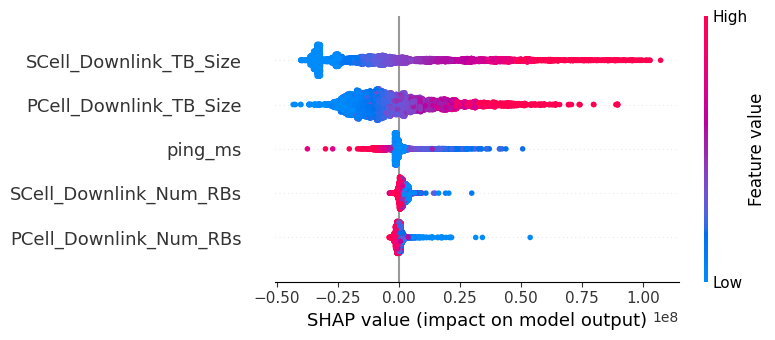

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x_test[main_cols])
shap.summary_plot(shap_values, x_test[main_cols])

In [ ]:
data.head(3)

,device,ping_ms,datarate,jitter,ts_gps,Latitude,Longitude,Altitude,speed_kmh,COG,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,Traffic Street Name,Traffic Distance,Pos in Ref Round,measurement,area,PCell_RSRP_1,PCell_RSRP_2,PCell_RSRP_max,PCell_RSRQ_1,PCell_RSRQ_2,PCell_RSRQ_max,PCell_RSSI_1,PCell_RSSI_2,PCell_RSSI_max,PCell_SNR_1,PCell_SNR_2,PCell_E-ARFCN,PCell_Downlink_Num_RBs,PCell_Downlink_TB_Size,PCell_Downlink_RBs_MCS_0,PCell_Downlink_RBs_MCS_1,PCell_Downlink_RBs_MCS_2,PCell_Downlink_RBs_MCS_3,PCell_Downlink_RBs_MCS_4,PCell_Downlink_RBs_MCS_5,PCell_Downlink_RBs_MCS_6,PCell_Downlink_RBs_MCS_7,PCell_Downlink_RBs_MCS_8,PCell_Downlink_RBs_MCS_9,PCell_Downlink_RBs_MCS_10,PCell_Downlink_RBs_MCS_11,PCell_Downlink_RBs_MCS_12,PCell_Downlink_RBs_MCS_13,PCell_Downlink_RBs_MCS_14,PCell_Downlink_RBs_MCS_15,PCell_Downlink_RBs_MCS_16,PCell_Downlink_RBs_MCS_17,PCell_Downlink_RBs_MCS_18,PCell_Downlink_RBs_MCS_19,PCell_Downlink_RBs_MCS_20,PCell_Downlink_RBs_MCS_21,PCell_Downlink_RBs_MCS_22,PCell_Downlink_RBs_MCS_23,PCell_Downlink_RBs_MCS_24,PCell_Downlink_RBs_MCS_25,PCell_Downlink_RBs_MCS_26,PCell_Downlink_RBs_MCS_27,PCell_Downlink_RBs_MCS_28,PCell_Downlink_RBs_MCS_29,PCell_Downlink_RBs_MCS_30,PCell_Downlink_RBs_MCS_31,PCell_Downlink_Average_MCS,PCell_Uplink_Num_RBs,PCell_Uplink_TB_Size,PCell_Uplink_Tx_Power_(dBm),PCell_Cell_ID,PCell_Downlink_frequency,PCell_Uplink_frequency,PCell_Downlink_bandwidth_MHz,PCell_Uplink_bandwidth_MHz,PCell_Cell_Identity,PCell_TAC,PCell_Band_Indicator,PCell_MCC,PCell_MNC_Digit,PCell_MNC,PCell_Allowed_Access,PCell_freq_MHz,SCell_RSRP_1,SCell_RSRP_2,SCell_RSRP_max,SCell_RSRQ_1,SCell_RSRQ_2,SCell_RSRQ_max,SCell_RSSI_1,SCell_RSSI_2,SCell_RSSI_max,SCell_SNR_1,SCell_SNR_2,SCell_E-ARFCN,SCell_Downlink_Num_RBs,SCell_Downlink_TB_Size,SCell_Downlink_RBs_MCS_0,SCell_Downlink_RBs_MCS_1,SCell_Downlink_RBs_MCS_2,SCell_Downlink_RBs_MCS_3,SCell_Downlink_RBs_MCS_4,SCell_Downlink_RBs_MCS_5,SCell_Downlink_RBs_MCS_6,SCell_Downlink_RBs_MCS_7,SCell_Downlink_RBs_MCS_8,SCell_Downlink_RBs_MCS_9,SCell_Downlink_RBs_MCS_10,SCell_Downlink_RBs_MCS_11,SCell_Downlink_RBs_MCS_12,SCell_Downlink_RBs_MCS_13,SCell_Downlink_RBs_MCS_14,SCell_Downlink_RBs_MCS_15,SCell_Downlink_RBs_MCS_16,SCell_Downlink_RBs_MCS_17,SCell_Downlink_RBs_MCS_18,SCell_Downlink_RBs_MCS_19,SCell_Downlink_RBs_MCS_20,SCell_Downlink_RBs_MCS_21,SCell_Downlink_RBs_MCS_22,SCell_Downlink_RBs_MCS_23,SCell_Downlink_RBs_MCS_24,SCell_Downlink_RBs_MCS_25,SCell_Downlink_RBs_MCS_26,SCell_Downlink_RBs_MCS_27,SCell_Downlink_RBs_MCS_28,SCell_Downlink_RBs_MCS_29,SCell_Downlink_RBs_MCS_30,SCell_Downlink_RBs_MCS_31,SCell_Downlink_Average_MCS,SCell_Uplink_Num_RBs,SCell_Uplink_TB_Size,SCell_Uplink_Tx_Power_(dBm),SCell_Cell_ID,SCell_Downlink_frequency,SCell_Uplink_frequency,SCell_Downlink_bandwidth_MHz,SCell_Uplink_bandwidth_MHz,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MCC,SCell_MNC_Digit,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,scenario,drive_mode,target_datarate,direction,measured_qos,operator
0,pc4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,0,None,-83.47625,-85.292500,-83.476250,-14.799375,-14.771875,-14.573125,-48.676250,-50.520625,-50.520625,23.591,21.963,1300.0,39870.0,6433701.0,NaN,156.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,78.0,453.0,1452.5,4480.0,6442.5,12867.5,10880.0,NaN,NaN,3031.5,27.0,973.0,28004.0,120.854749,246.0,1300.0,19300.0,20,20,33802242.0,1494.0,3.0,262.0,2.0,1.0,0.0,1800.0,-84.980625,-86.231875,-84.930000,-10.736250,-9.635625,-9.614375,-54.243750,-56.594375,-56.594375,25.171,24.226,3050.0,46504.0,8422381.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,668.0,9604.0,32332.0,NaN,NaN,3900.0,28.0,NaN,NaN,NaN,431.0,3050.0,21050.0,20,20,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,A3D,platoon,350000000,

<Axes: xlabel='datarate', ylabel='Count'>

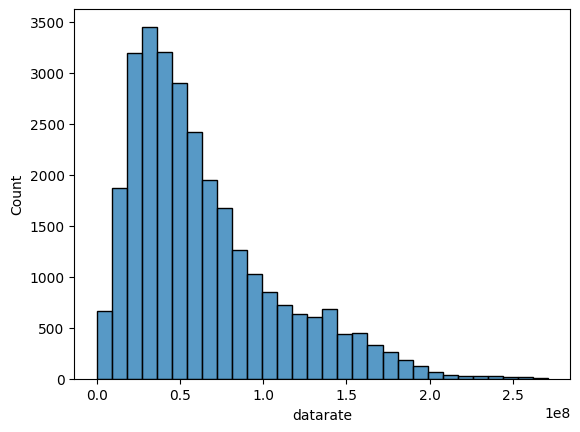

In [ ]:
sns.histplot(y, bins=30)

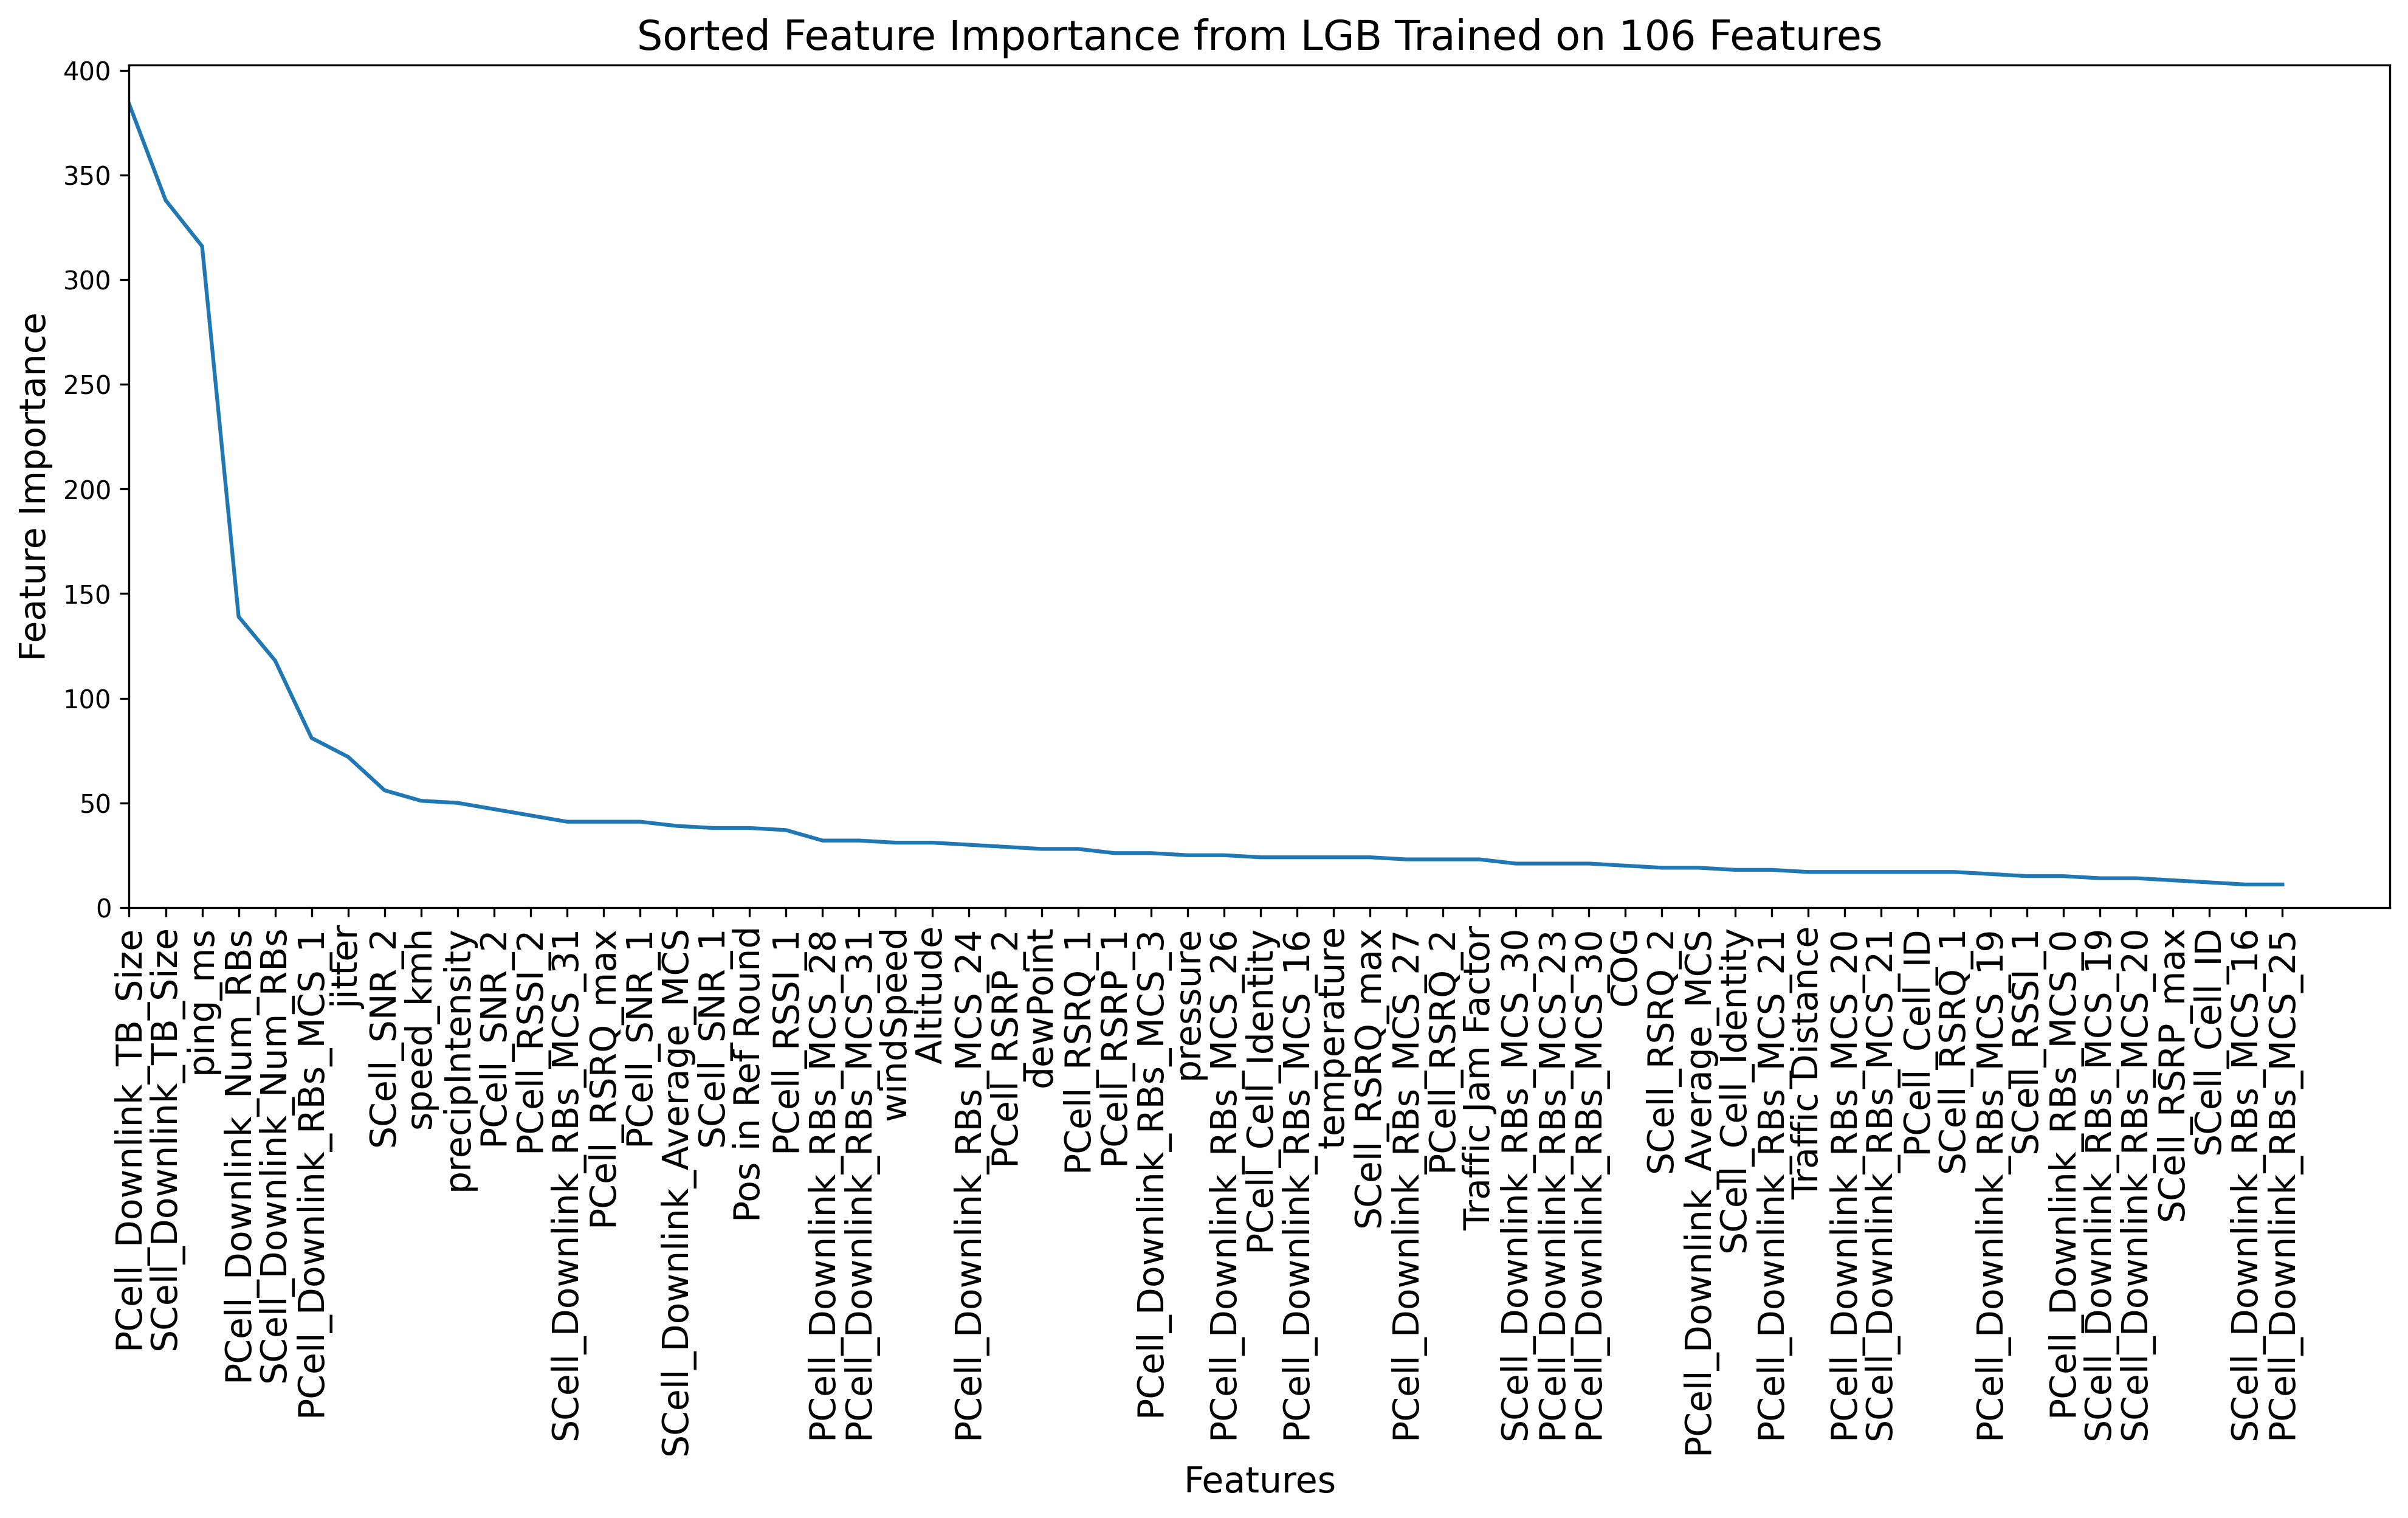

In [ ]:
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': x_test.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:60]

# Create a line plot with customizations
plt.figure(figsize=(16, 6), dpi=300)
plt.plot(importance_df['Feature'], importance_df['Importance'], linestyle='-')  # Line with markers

# Set y-axis to start at 0 (ensures line starts from axis)
plt.ylim(bottom=0)

# set x-axis to start at 0
plt.xlim(left=0)

# Increase font size for better readability
plt.xticks(rotation=90, fontsize=14)  # Feature names
plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature Importance', fontsize=14)
plt.title('Sorted Feature Importance from LGB Trained on top 60 Features', fontsize=16)
# plt.grid(True)  # Add grid for better visualization (optional)
# plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()

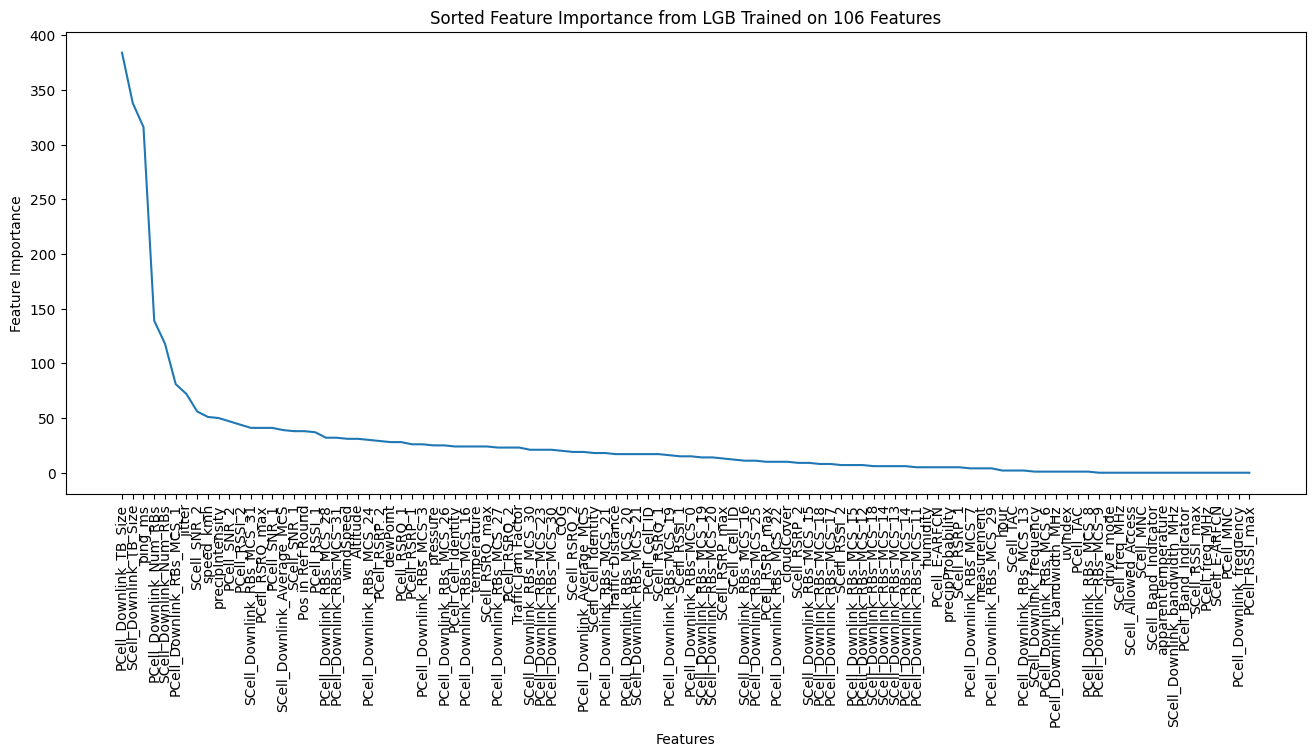

In [ ]:
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
importance_df = pd.DataFrame({'Feature': x_test.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of sorted feature importances
plt.figure(figsize=(16, 6))
plt.plot(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Sorted Feature Importance from LGB Trained on 106 Features')
plt.show()

In [ ]:
# # threshold observed from the elbow of the line graph as 50
# threshold = 50

# # pick column above threshold (50) as main columns
# main_cols = importance_df[importance_df.Importance > threshold].Feature.tolist()
# print(f'Selected Main Features: {len(main_cols)}\n')
# main_cols

## Final Modelling

In [19]:
main_cols = [
    'PCell_Downlink_TB_Size',
    'SCell_Downlink_TB_Size',
    'ping_ms',
    'PCell_Downlink_Num_RBs',
    'SCell_Downlink_Num_RBs',
    'speed_kmh'
 ]

In [20]:
def train_algos(X_train, X_test, y, y_test):
  rf = RF()
  # rf.fit(X_train, y)

  cat = CAT(silent=True)
  # cat.fit(X_train, y)

  hist = HIST()
  # hist.fit(X_train, y)

  lgb = LGB(verbose=-100)
  # lgb.fit(X_train, y)

  mlp = MLP()
  # mlp.fit(X_train, y)

  models = {"Random Forest":rf, 'Catboost':cat, 'HistGradientBoost':hist, 'LightGBM':lgb, 'MLP':mlp}

  for model in models:

    print('='*50)
    print(model)
    print('='*50)
    reg = models[model]
    reg.fit(X_train, y)
    eval(y_test, reg.predict(X_test))
    print('\n')

In [21]:
model = MLP(hidden_layer_sizes=(24), max_iter=100, solver='adam')

In [22]:
# fit model
X_train = X[main_cols]

model.fit(X_train, y)

MLPRegressor(hidden_layer_sizes=24, max_iter=100)

In [23]:
  # filtering the test set as well for main features
X_test = x_test[main_cols]

# making predictions
y_pred = model.predict(X_test)

# show the new R2 Score
eval(y_test, y_pred)

RMSE: 5221751.957489159
MAE: 3090360.877272297
MAPE: 0.3569178422409478
R2: 0.9446213704611076
EVS: 0.9447866639972935


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


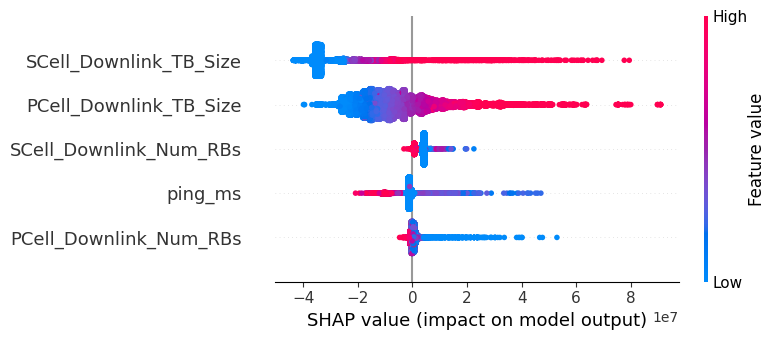

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

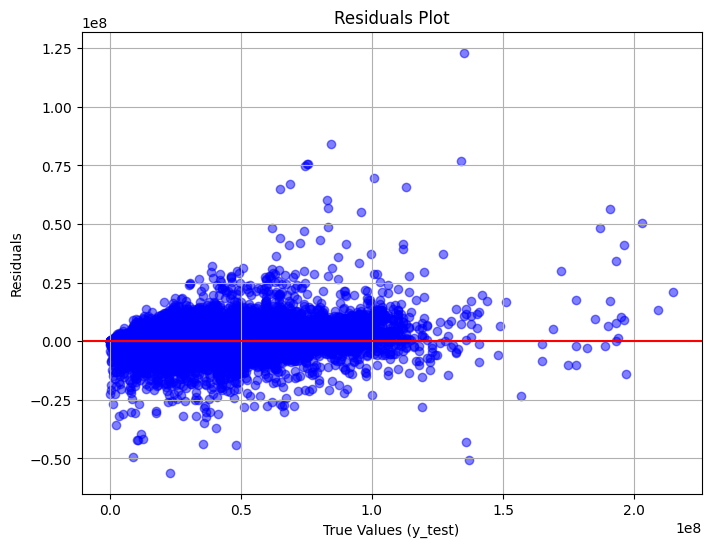

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are your true and predicted target values, respectively
# Replace them with your actual data

# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.title('Residuals Plot')
plt.xlabel('True Values (y_test)')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')  # Adding a horizontal line at y=0 for reference
plt.grid(True)
plt.show()

## Save Model

In [24]:
# save model weights
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [25]:
# Load the model from the file
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [26]:
# making predictions
y_pred = loaded_model.predict(X_test)

# show the new R2 Score
final_r2 = r2_score(y_test, y_pred)
print('===================================')
print('    PREDICTION FROM LOADED MODEL   ')
print('===================================')
print(f'R2 Score: {final_r2}')

    PREDICTION FROM LOADED MODEL   
R2 Score: 0.9446213704611076
